In [6]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt 
import datetime as dt
import time

from keras.models import Sequential
#from keras.layers.containers import Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU 
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback




In [7]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time
import pandas as pd

def load_snp_returns():
    f=pd.read_csv('/Users/adashaw/Desktop/Deep-Trading/other_LTSM_model/AAPL_data.csv',header=0)
    raw_data = f['Open'].values-f['Close'].values
    raw_dates= f['Date'].values
    return raw_data, raw_dates


def load_snp_close():
    f=pd.read_csv('/Users/adashaw/Desktop/Deep-Trading/other_LTSM_model/AAPL_data.csv',header=0)
    raw_data = f['close'].values
    raw_dates= f['date'].values
    return raw_data, raw_dates


def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    #takes in timeseries
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]

            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)

            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]

        except:
            break

        X.append(x_i) #train only
        Y.append(y_i) #train and predict

    return X, Y


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    #X_train = np.expand_dims(X_train,axis=1)
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test



In [8]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.i = 0 
        self.save_every = 5000

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1    
        if self.i % self.save_every == 0:    
            pred = model.predict(X_train)
            self.predictions.append(pred)

Data loading...
Building model...


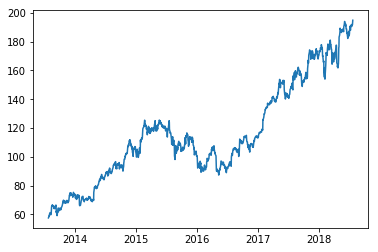

In [9]:
TARGET_TIME = 1 
LAG_SIZE = 1 

print('Data loading...')  
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)
plt.savefig('data.png')
TRAIN_SIZE = 20
TARGET_TIME = 1 
LAG_SIZE = 1 
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)


print('Building model...')
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam',
              loss='mse')

Train on 1002 samples, validate on 112 samples
Epoch 1/5
1002/1002 [==============================] - 0s 27us/step - loss: 0.0219 - val_loss: 0.0187
Epoch 2/5
1002/1002 [==============================] - 0s 26us/step - loss: 0.0218 - val_loss: 0.0147
Epoch 3/5
1002/1002 [==============================] - 0s 26us/step - loss: 0.0187 - val_loss: 0.0128
Epoch 4/5
1002/1002 [==============================] - 0s 25us/step - loss: 0.0196 - val_loss: 0.0140
Epoch 5/5
124/124 [==============================] - 0s 10us/step
0.009760974906384945
------------
[[-1.33961397 -1.17095359 -1.82101506 ...  0.92331113 -0.06761291
  -1.16039903]
 [-1.04737059 -1.65161978 -0.6619535  ... -0.02178648 -1.03755985
  -0.90692562]
 [-1.44001007 -0.5424009  -0.55129905 ... -0.88306897 -0.76458611
  -1.81624092]
 ...
 [-0.75202049 -0.92673699 -1.81649695 ...  1.18603847  0.84631194
   1.32516457]
 [-1.0030768  -1.87679754 -1.15875795 ...  0.73801035  1.20823097
   1.06843565]
 [-1.94749763 -1.24797264 -1.331544

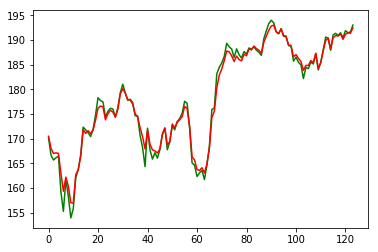

In [25]:
model.fit(X_train,
          Y_train,
          epochs=5,
          batch_size = 128,
          verbose=1,
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print(score)


params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])
print('------------')
print(X_test)
print('------------')
predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)


mse = mean_squared_error(predicted, new_predicted)
print('MSE: '+ str(mse))

try:
    fig = plt.figure()
    #plt.plot(Y_test[:150], color='black') # BLUE - trained RESULT
    #plt.plot(predicted[:150], color='blue') # RED - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    plt.show()
    plt.savefig('test.png')
except Exception as e:
    print(str(e))

In [15]:
print(X_test)

[[173.180875, 2.816915366651083], [173.22601500000002, 2.7603012241918474], [173.071245, 3.025936715213159], [172.959135, 3.248942190971548], [172.71954, 3.554199346181922], [172.49879500000003, 3.7913024964350988], [171.877235, 4.7697363082538455], [170.959035, 5.963965795028927], [170.39749999999998, 6.2686464057242866], [169.66383000000002, 6.765358375659046], [168.714375, 7.5314856711591105], [167.80995000000001, 7.930266453310381], [167.12953, 7.807526373576973], [166.574945, 7.634971132982429], [166.02692499999998, 7.1985534593329925], [165.75088499999998, 6.836789810084481], [165.48664, 6.488107160597762], [165.26592999999997, 6.20926972454088], [165.00438499999998, 5.8673827595679295], [164.95395499999998, 5.803757030706489], [165.20721999999995, 6.1104030642503435], [165.61347999999998, 6.670460435802013], [166.16694999999999, 7.172621440414934], [166.75608, 7.5786262761532175], [167.16699, 7.753217369189387], [167.62081, 7.961211087384882], [168.46614, 7.923323121291974], [16